In [1]:
#install necessary libraries and dependencies
!pip install tensorflow opencv-python matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import tensorflow as tf 
import os #operating system interaction

In [3]:
import cv2 #for realtime computer vision
import imghdr #to determine the image type

In [4]:
#preprocessing 
#load data
#remove dodgy images

train_data_dir = 'data/train' #train data directory
test_data_dir = 'data/test' #test data directory

image_exts = ['jpeg','jpg', 'bmp', 'png'] #valid image extensions

In [5]:
#function to iterate through all images and remove ones with invalid extensions
def img_ext(data_dir):
    for image_class in os.listdir(data_dir):
        for image in os.listdir(os.path.join(data_dir, image_class)):
            image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            
img_ext(train_data_dir)
img_ext(test_data_dir)

In [6]:
tf.keras.utils.set_random_seed(12) #random seeding for consistency

batch_size = 32
#desired image dimensions
img_height = img_weight = 256

In [7]:
#data visualization
#import necessary libraries
import numpy as np
from matplotlib import pyplot as plt
train_data = tf.keras.utils.image_dataset_from_directory('data/train') #load data from train drectory

Found 1924 files belonging to 2 classes.


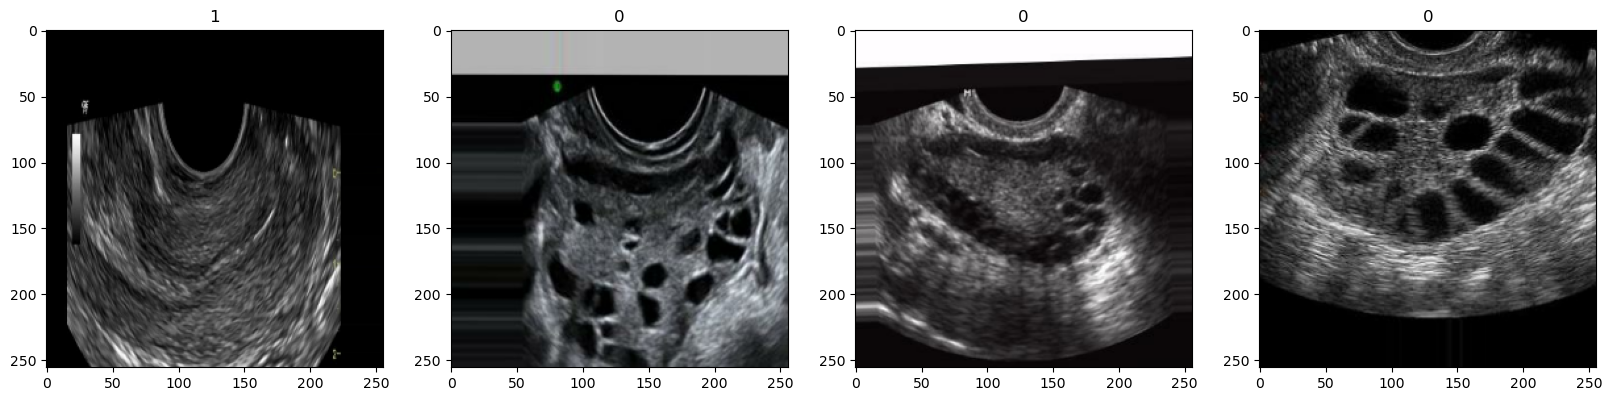

In [8]:
train_data_iterator = train_data.as_numpy_iterator() #to iterate through the dataset
batch = train_data_iterator.next() #display the data in batch
#display image and their classes
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
    
    #from our visuualized images, we can see that label 0 indicates infected and 1 indicates not infected

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#data augmention and generators for training and validation
train_datagen = ImageDataGenerator(rescale = 1.0/255.0, #rescale pixel values to range 0 to 1
                                   shear_range = 0.2,  #apply shearing transformation to images
                                   zoom_range = 0.2, #apply random zoom to images up to 20%
                                   width_shift_range=0.2, #randomly shift the width of images up to 20%
                                   height_shift_range=0.2, #randomly shift the heigth of images up to 20%
                                   horizontal_flip = True, #horizontally flip images randomly
                                   vertical_flip=True, #vertically flip images randomly
                                   rotation_range=20, #randomly rotate images by up to 20 degrees
                                   validation_split=0.2, #split data into training and validation using 80:20 ratio
                                   fill_mode='nearest' #fill newly created pixels with the nearest pixel value
                                  )
#generator for training data
train_gen = train_datagen.flow_from_directory(train_data_dir,
                                              class_mode='categorical', #label encoding type for one-hot encoding
                                              classes=['infected', 'notinfected'], #prediction classes expected
                                              target_size=(img_height, img_weight), #resize image to specified dimensions
                                              batch_size=batch_size, #number of images per batch
                                              subset='training', #subset of data (in this case training)
                                              seed=12 #seeding for consistency
                                             )
#genarator for validation data
validation_gen = train_datagen.flow_from_directory(train_data_dir,
                                              class_mode='categorical', #label encoding type for one-hot encoding
                                              classes=['infected', 'notinfected'], #prediction classes expected
                                              target_size=(img_height, img_weight), #resize image to specified dimensions
                                              batch_size=batch_size, #number of images per batch
                                              subset='validation', #subset of data (in this case validation)
                                              seed=12 #seeding for consistency
                                             )

Found 1540 images belonging to 2 classes.
Found 384 images belonging to 2 classes.


In [11]:
#build model
#import necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

model = Sequential()

#convolutional layer with 64 filters, each of size of 3by5 pixels, stride of 1 and ReLU activation
model.add(Conv2D(64, (5,5), 1, activation='relu', input_shape=(256,256,3)))

#max pooling layer scans through the values return after ReLU activation, condenses and returns the max value
model.add(MaxPooling2D(2, 2))

#convolutional layer with 32 filters
model.add(Conv2D(32, (5,5), 1, activation='relu'))

#max pooling layer
model.add(MaxPooling2D(2, 2))

#convolutional layer with 16 filters
model.add(Conv2D(16, (5,5), 1, activation='relu'))

#max pooling layer
model.add(MaxPooling2D(2, 2))

#flatten layer to flatten down the channel values to a single value
model.add(Flatten())

#fully connected layers with 256 neurons and ReLU activation
model.add(Dense(256, activation='relu'))

#model.add(Dropout(0.5))

#model.add(Dense(256, activation='relu'))

#model.add(Dropout(0.5))

#last layer is a single dense layer with sigmoid activation to represent our expected output of 0 or 1
#0 represents infected and 1 represent notinfected
model.add(Dense(2, activation='sigmoid'))

In [12]:
#import optimizer
from tensorflow.keras.optimizers import Adam

#opt=Adam() #optimizer for model compilation with learning rate of 0.01
model.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
#early stopping allows to stop training when valudation loss does not decrease after 15 consequtive epochs.
earlyStopping = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=15)

In [14]:
history = model.fit(
    train_gen,
    validation_data=validation_gen,
    callbacks=[earlyStopping],
    batch_size=batch_size,
    verbose=1,
    epochs=20)

Epoch 1/20
49/49 [==============================] - 178s 4s/step - loss: 0.4761 - accuracy: 0.7422 - val_loss: 0.1497 - val_accuracy: 0.9453
Epoch 2/20
49/49 [==============================] - 177s 4s/step - loss: 0.1018 - accuracy: 0.9643 - val_loss: 0.2014 - val_accuracy: 0.9349
Epoch 3/20
49/49 [==============================] - 168s 3s/step - loss: 0.0415 - accuracy: 0.9883 - val_loss: 0.0750 - val_accuracy: 0.9818
Epoch 4/20
49/49 [==============================] - 162s 3s/step - loss: 0.0312 - accuracy: 0.9916 - val_loss: 0.0540 - val_accuracy: 0.9818
Epoch 5/20
49/49 [==============================] - 159s 3s/step - loss: 0.0480 - accuracy: 0.9870 - val_loss: 0.0414 - val_accuracy: 0.9870
Epoch 6/20
49/49 [==============================] - 157s 3s/step - loss: 0.0307 - accuracy: 0.9909 - val_loss: 0.0133 - val_accuracy: 0.9948
Epoch 7/20
49/49 [==============================] - 163s 3s/step - loss: 0.0219 - accuracy: 0.9948 - val_loss: 0.0303 - val_accuracy: 0.9870
Epoch 8/20
49

In [15]:
model.summary() #to view the architecture at every layer

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 32)      51232     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 57, 57, 16)        12816     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 16)       0

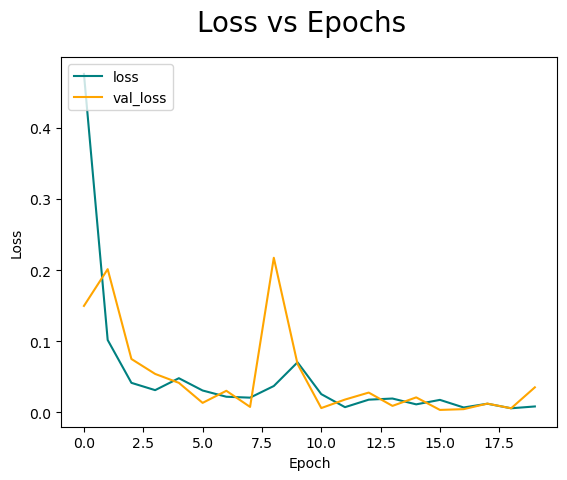

In [16]:
#plot the model training and validation performance loss
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss vs Epochs', fontsize=20)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

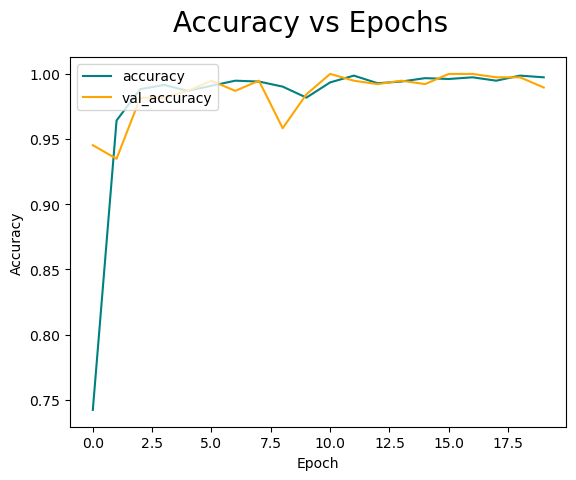

In [17]:
#plot the model training and validation performance accuracy
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy vs Epochs', fontsize=20)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

In [18]:
#evaluation and testing
#import the neccesary libraries
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [24]:
#load the test data
#test_dat = train_datagen.flow_from_directory(
    #test_data_dir,
    #seed=12,
    #target_size=(img_height, img_weight),
   # batch_size=batch_size
#)
test_data = tf.keras.utils.image_dataset_from_directory('data/test')


Found 1922 files belonging to 2 classes.


In [43]:
#normalize test data
test_data_iterator = test_data.as_numpy_iterator()
test_data = test_data.map(lambda x,y: (x/255, y))
test_data.as_numpy_iterator().next()

(array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          ...,
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],
 
         [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          ...,
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],
 
         [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          ...,
          [0.00000000e+00, 0.00000000e+00, 0.0000

In [44]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [45]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 1s 995ms/step


ValueError: Shapes (32, 2) and (32,) are incompatible

In [46]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


In [47]:
#test the model on real infected ultrasound image
test_img = cv2('infected2')
resize = tf.image.resize(test_img, (256,256)) #resize the image
plt.imshow(resize.numpy().astype(int))
plt.show()

TypeError: 'module' object is not callable

In [48]:
#test the model on real notinfected ultrasound image
test_img = cv2('notinfected2')
resize = tf.image.resize(test_img, (256,256)) #resize the image
plt.imshow(resize.numpy().astype(int))
plt.show()

TypeError: 'module' object is not callable

In [49]:
#make prediction on normalized test image
prd = model.predict(np.expand_dims(resize/255, 0))

NameError: name 'resize' is not defined

In [50]:
prd

NameError: name 'prd' is not defined

In [51]:
if prd > 0.5: 
    print(f'Predicted class is Not Infected')
else:
    print(f'Predicted class is Infected')

NameError: name 'prd' is not defined

In [52]:
#save the model
from tensorflow.keras.models import load_model

In [53]:
model.save(os.path.join('models','PCOSclassifier.h5'))

In [54]:
new_model = load_model('PCOSclassifier.h5')

OSError: No file or directory found at PCOSclassifier.h5

In [55]:
new_model.predict(np.expand_dims(resize/255, 0))

NameError: name 'new_model' is not defined

In [ ]:
#RNN using LSTM cells